## Load Data and Packages

In [154]:
# Download data from kaggle
import kagglehub
path = kagglehub.dataset_download("luizclaudioandrade/naip-chesapeake-sample")

print("Path to dataset files:", path)

Path to dataset files: /Users/bermane/.cache/kagglehub/datasets/luizclaudioandrade/naip-chesapeake-sample/versions/7


In [155]:
# load packages
import os

import torch
import torch.nn as nn

from torch.utils.data import DataLoader
from torchgeo.datasets import NAIP, ChesapeakeDE, stack_samples
from torchgeo.samplers import RandomGeoSampler

import albumentations as A
from albumentations.pytorch import ToTensorV2

import numpy as np
import matplotlib.pyplot as plt

## Initialize Parameters

In [156]:
# define landcover labels
"""
Complete 18-class dataset.

    This version of the dataset is composed of 18 classes:

    0. No Data: Background values
"""

names=[
    'No Data',
    'Water',
    'Natural Succession',
    'Impervious Roads',
    'Impervious Structures',
    'Impervious, Other',
    'Tree Canopy over Impervious',
    'Tree Canopy over Turf Grass',
    'Turf Grass',
    'Pervious Developed, Other',
    'Harvested Forest',
    'Extractive', 
    'Forest',
    'Tree Canopy, Other',
    'Wetlands, Riverine Non-forested',
    'Wetlands, Terrence Non-forested',
    'Cropland',
    'Pasture/Hay',
    'Wetlands, Tidal Non-forested'
]

# subclasses use the 13 class cmap by default
cmap = [
    (0, 0, 0),
    (0, 197, 255),
    (0, 168, 132),
    (38, 115, 0),
    (76, 230, 0),
    (163, 255, 115),
    (255, 170, 0),
    (255, 0, 0),
    (156, 156, 156),
    (0, 0, 0),
    (115, 115, 0),
    (230, 230, 0),
    (255, 255, 115),
    (197, 0, 255)
]
np.array(cmap)

array([[  0,   0,   0],
       [  0, 197, 255],
       [  0, 168, 132],
       [ 38, 115,   0],
       [ 76, 230,   0],
       [163, 255, 115],
       [255, 170,   0],
       [255,   0,   0],
       [156, 156, 156],
       [  0,   0,   0],
       [115, 115,   0],
       [230, 230,   0],
       [255, 255, 115],
       [197,   0, 255]])

## Load and Pre-Process Data

In [157]:
# define image transformations
transform = A.Compose([
    A.HorizontalFlip(),
    A.ShiftScaleRotate(),
    A.OneOf([
        A.RandomBrightnessContrast(),
        A.RandomGamma(),
    ]),
    A.CoarseDropout(max_height=32, max_width=32, max_holes=5)
])

In [158]:
# path to images
naip_root = os.path.join(path, 'naip_images')
chesapeake_root = os.path.join(path, "chesapeake_labels")

# load raster datasets
naip = NAIP(naip_root)
chesapeake = ChesapeakeDE(chesapeake_root, crs=naip.crs, res=naip.res, download=True)

# create intersection dataset
dataset = naip & chesapeake

In [159]:
# create a custom geo sampler
sampler = RandomGeoSampler(dataset, size=256, length=500)

# create a dataloader
dataloader = DataLoader(dataset, sampler=sampler, collate_fn=stack_samples)

## Visualize Example Images

In [160]:

# define a colormap to plot predictions
# Perform colour coding on the outputs
def colour_code_segmentation(image, colors):
    """
    Given a 1-channel array of class keys, colour code the segmentation results.
    # Arguments
        image: single channel array where each value represents the class key.
        colormap: the list os rgb colors for each class

    # Returns
        Colour coded image for segmentation visualization
    """
    colour_codes = np.array(colors)
    return colour_codes[image]

In [161]:
# create a helper function for data visualization
import torchvision.transforms as transforms
reverse_transform = transforms.Compose([
            transforms.ToPILImage(),
            transforms.Resize(size=256),
        ])

# helper function for data visualization
def visualize(**images):
    """PLot images in one row."""
    n = len(images)
    plt.figure(figsize=(16, 5))
    for i, (name, image) in enumerate(images.items()):
        plt.subplot(1, n, i + 1)
        plt.xticks([])
        plt.yticks([])
        plt.title(' '.join(name.split('_')).title())
        plt.imshow(image)
    plt.show()

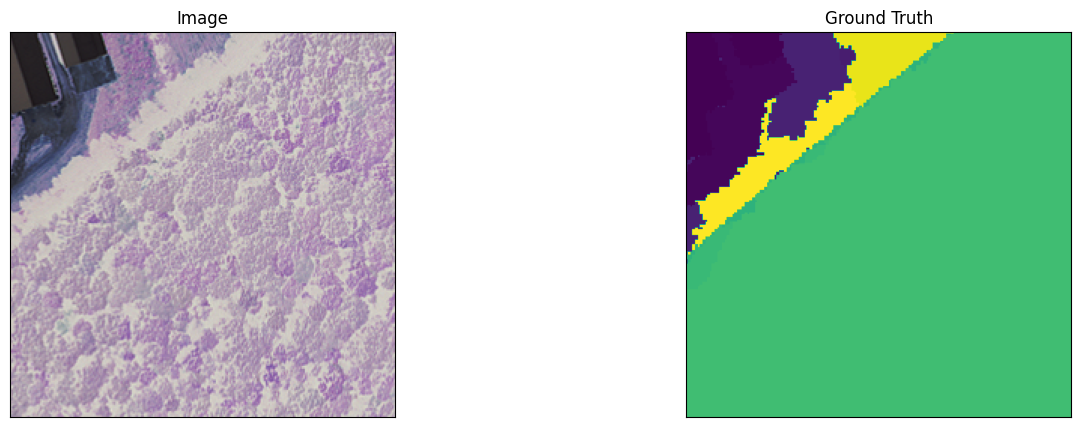

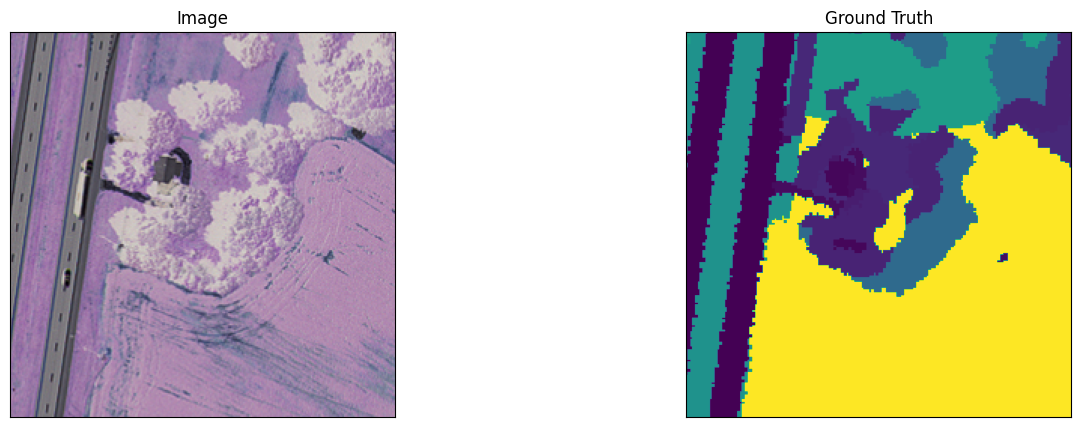

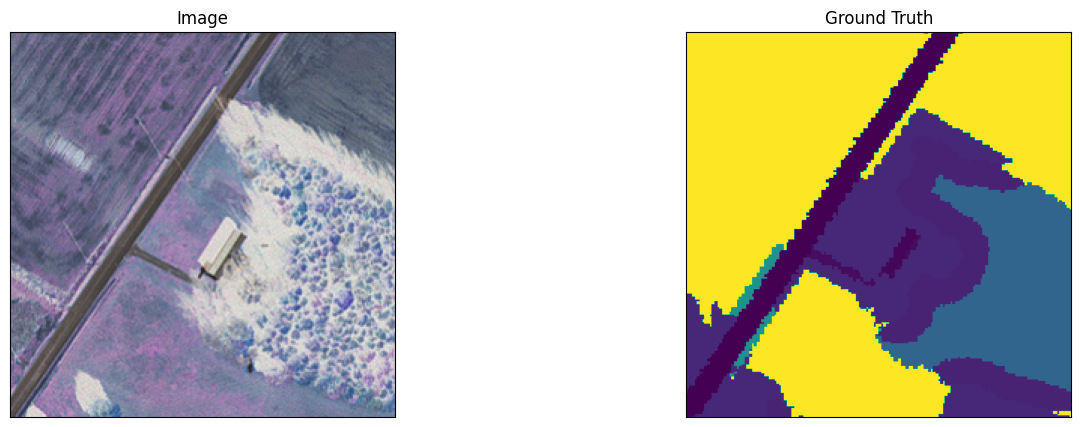

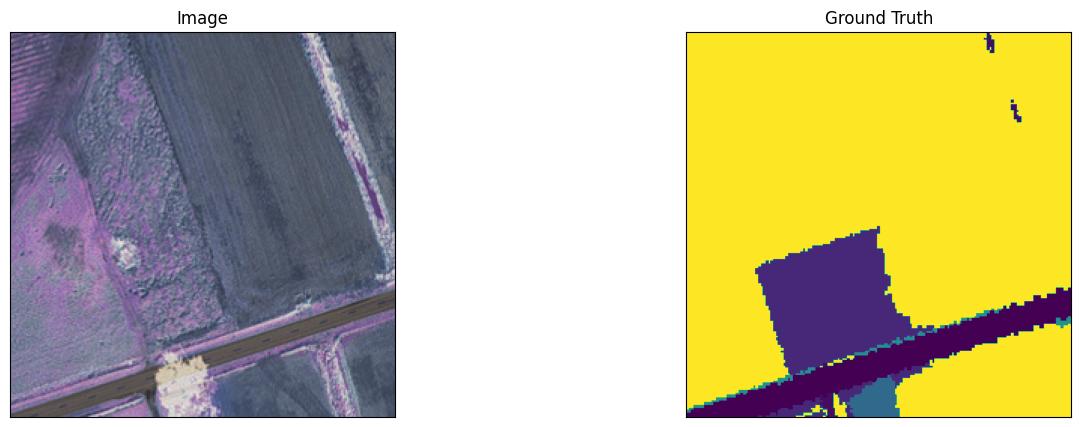

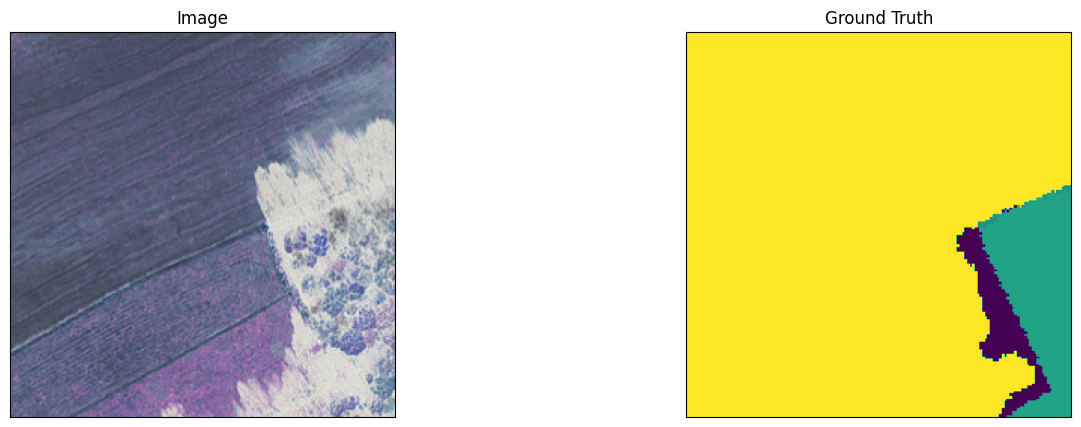

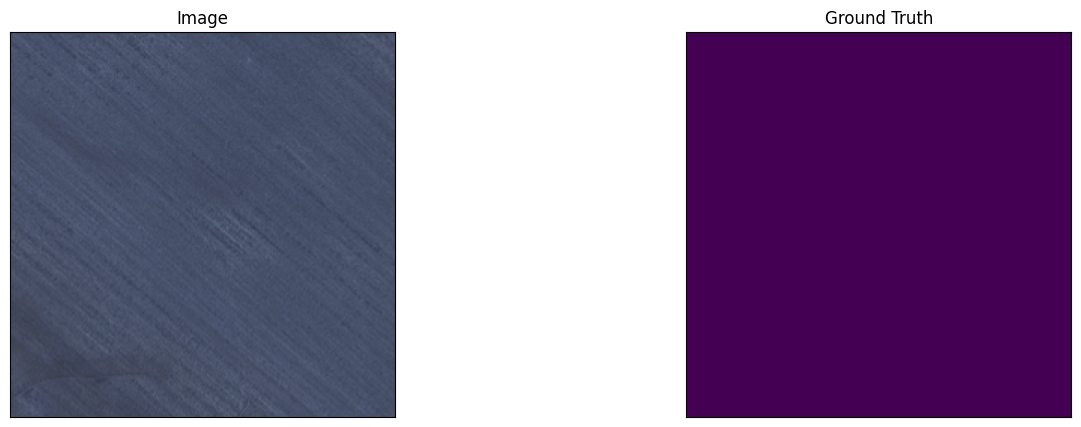

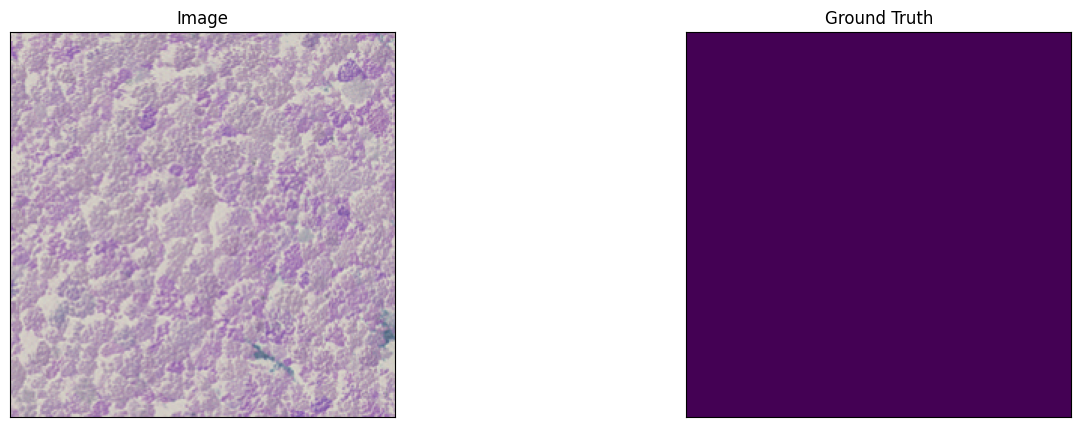

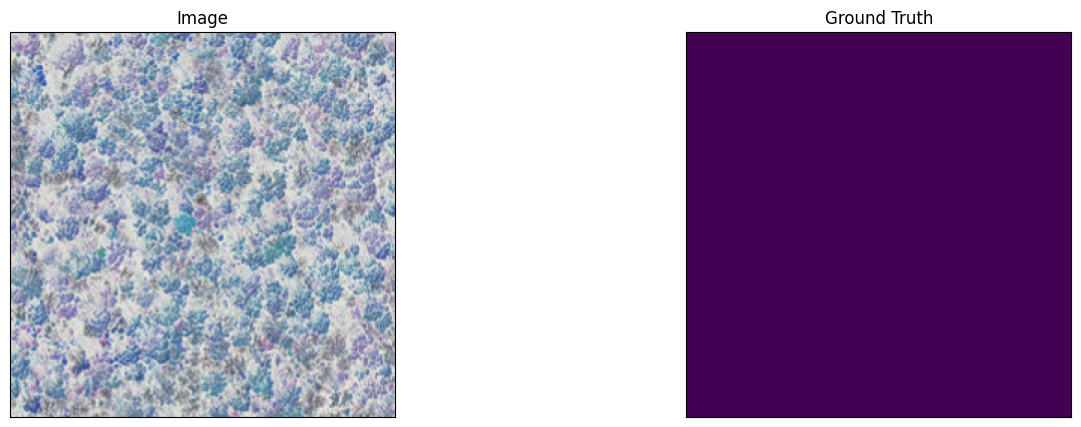

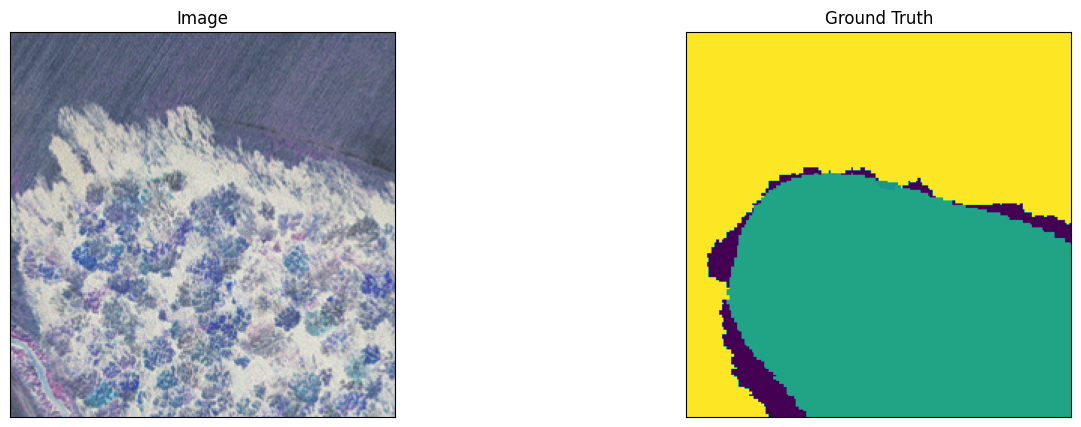

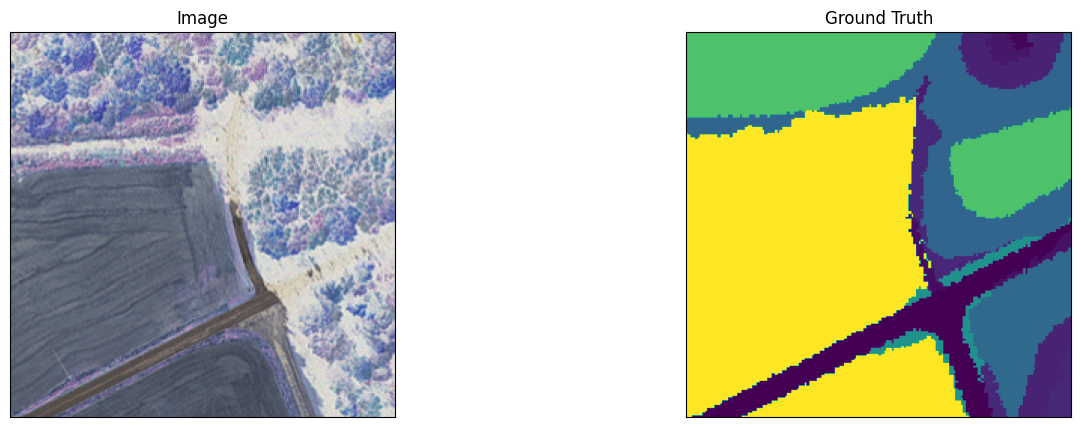

In [162]:
# visualize a set of 10 samples
n = 0
for sample in dataloader:
    if n == 10:
        break
    image, gt_mask = sample['image'], sample['mask']
    
    #gt_mask = colour_code_segmentation(gt_mask, chesapeake.cmap)
        
    visualize(
        image=reverse_transform(image.squeeze()[:3]),
        ground_truth = gt_mask.squeeze(),
    )
    n += 1

In [181]:
# look at label distribution across samples
# Dictionary to accumulate class counts
class_counts = {}

# Iterate over the dataloader
for sample in dataloader:
    labels = sample['mask']  # Assuming labels are stored under the key 'label'

    # Flatten the label tensor to count all values
    unique_values, counts = torch.unique(labels, return_counts=True)
    
    # Update the class counts in the dictionary
    for value, count in zip(unique_values, counts):
        class_id = int(value.item())
        if class_id in class_counts:
            class_counts[class_id] += int(count.item())
        else:
            class_counts[class_id] = int(count.item())

# Convert to percentages (optional)
total_pixels = sum(class_counts.values())
class_distribution = {k: v / total_pixels for k, v in class_counts.items()}

print("Class Counts:", class_counts)
print("Class Distribution (percentages):", class_distribution)


Class Counts: {32: 158422, 41: 4657069, 82: 14687865, 21: 406228, 28: 1377290, 23: 456918, 22: 268244, 24: 38078, 26: 25288, 42: 202731, 52: 398498, 62: 166240, 65: 6425503, 27: 471098, 25: 9090, 84: 2580632, 56: 73241, 55: 95052, 64: 39122, 15: 62071, 81: 78747, 13: 52545, 14: 14278, 29: 4102, 71: 31, 72: 1578, 63: 465, 83: 170, 87: 37, 88: 17367}
Class Distribution (percentages): {32: 0.00483465576171875, 41: 0.14212246704101564, 82: 0.4482380676269531, 21: 0.0123970947265625, 28: 0.04203155517578125, 23: 0.01394403076171875, 22: 0.0081861572265625, 24: 0.00116204833984375, 26: 0.000771728515625, 42: 0.006186859130859375, 52: 0.01216119384765625, 62: 0.0050732421875, 65: 0.19609078979492187, 27: 0.01437677001953125, 25: 0.00027740478515625, 84: 0.078754638671875, 56: 0.002235137939453125, 55: 0.0029007568359375, 64: 0.00119390869140625, 15: 0.001894256591796875, 81: 0.002403167724609375, 13: 0.001603546142578125, 14: 0.00043572998046875, 29: 0.00012518310546875, 71: 9.46044921875e-07

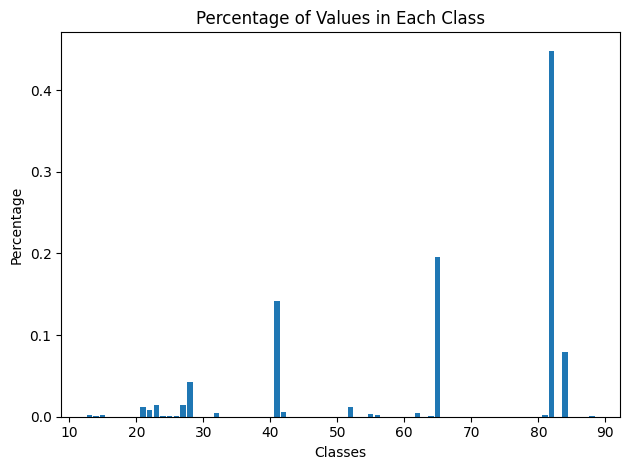

In [182]:
# plot histogram
plt.bar(class_distribution.keys(), class_distribution.values())
plt.title('Percentage of Values in Each Class')
plt.xlabel('Classes')
plt.ylabel('Percentage')

plt.tight_layout()
plt.show()

In [183]:
# total number of classes
unique_values = set(class_distribution.keys())
len(unique_values)

30

In [184]:
# label mapping
label_mapping = {key: idx for idx, key in enumerate(class_distribution.keys())}
label_mapping # doesn't matter how they map from 0-30 just need 31 classes 0-30

{32: 0,
 41: 1,
 82: 2,
 21: 3,
 28: 4,
 23: 5,
 22: 6,
 24: 7,
 26: 8,
 42: 9,
 52: 10,
 62: 11,
 65: 12,
 27: 13,
 25: 14,
 84: 15,
 56: 16,
 55: 17,
 64: 18,
 15: 19,
 81: 20,
 13: 21,
 14: 22,
 29: 23,
 71: 24,
 72: 25,
 63: 26,
 83: 27,
 87: 28,
 88: 29}

## Create Functions for Training Model

In [185]:
# build accuracies outside of list
train_accuracies = []
validation_accuracies = []

# function for training
def train(dataloader, model, loss_fn, optimizer, epoch, label_mapping):

    size = 256 * 256 # number of predictions each batch (single 256x256 image)
    num_batches = len(dataloader) # number of batches

    model.train()

    train_loss, correct = 0, 0

    for batch, sample in enumerate(dataloader):
        # reset gradients
        optimizer.zero_grad()

         # convert labels to 0-30 range
        # need to squeeze tensor to 256 x 256
        y_mapped = torch.tensor([label_mapping[label.item()] for label in sample['mask'].squeeze().flatten()]).view(256, 256).unsqueeze(0)

        # move X and y to GPU for faster training
        X, y = sample['image'].to(device), y_mapped.to(device)

        # make prediction
        pred = model(X)

        # calculate loss
        loss = loss_fn(pred, y) # now need to unsqueeze

        # backpropagation
        loss.backward() # compute parameter gradients
        optimizer.step() # update parameters

        # update training loss
        train_loss += loss.item()

        # calculate training accuracy
        correct += (pred.argmax(1) == y).type(torch.float).sum().item()

    # loss and accuracy
    train_loss = train_loss / num_batches
    accuracy = 100 * correct / (size * num_batches)
    
    # use this accuracy list for plotting accuracy with matplotlib
    train_accuracies.append(accuracy)

    # Print training accuracy and loss at the end of epoch
    print(f" Epoch: {epoch + 1}, Training Accuracy: {accuracy:.2f}%, Training Loss: {train_loss:.4f}")

# function for validation
def validation(dataloader, model, loss_fn,t):
    
    size = len(dataloader.dataset) # total number of images inside of loader
    num_batches = len(dataloader) # number of batches
    
    validation_loss, correct = 0, 0
    
    # sets the PyTorch model to evaluation mode, it will disable dropout layer
    model.eval()
    
    with torch.no_grad(): #  disable gradient calculation
        for X, y in dataloader:
            
            # move X and y to GPU for faster training
            X, y = X.to(device), y.to(device)
            pred = model(X) # make prediction
            validation_loss += loss_fn(pred, y).item() 
            
            # if prediction is correct add 1 to correct variable.
            correct += (pred.argmax(1) == y).type(torch.float).sum().item()
    
    # loss and accuracy
    validation_loss /= num_batches
    accuracy = 100 * correct / size

    validation_accuracies.append(accuracy)

    # Print test accuracy and loss at the end of epoch
    print(f" Epoch: {t+1}, Validation Accuracy: {accuracy:.2f}%, Validation Loss: {validation_loss:.4f}")

In [186]:
# if GPU is available , use it while training 
device = "mps" if torch.mps.is_available() else "cpu" 
device

'mps'

In [187]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class SimpleCNN(nn.Module):
    def __init__(self, num_classes=31):
        super(SimpleCNN, self).__init__()
        
        # Initial conv layer: input has 4 channels, output 32 channels
        self.conv1 = nn.Conv2d(4, 32, kernel_size=3, padding=1)
        self.act1 = nn.ReLU()
        self.pool1 = nn.MaxPool2d(2)  # Reduces size to (128, 128)
        
        # Second conv layer
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.act2 = nn.ReLU()
        self.pool2 = nn.MaxPool2d(2)  # Reduces size to (64, 64)
        
        # Third conv layer
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.act3 = nn.ReLU()
        self.pool3 = nn.MaxPool2d(2)  # Reduces size to (32, 32)

        # Upsampling layers to bring back to the original spatial size
        self.upsample1 = nn.ConvTranspose2d(128, 64, kernel_size=2, stride=2)  # Upsample to (64, 64)
        self.upsample2 = nn.ConvTranspose2d(64, 32, kernel_size=2, stride=2)   # Upsample to (128, 128)
        self.upsample3 = nn.ConvTranspose2d(32, num_classes, kernel_size=2, stride=2)  # Upsample to (256, 256)

    def forward(self, x):
        # Downsampling path
        x = self.pool1(self.act1(self.conv1(x)))
        x = self.pool2(self.act2(self.conv2(x)))
        x = self.pool3(self.act3(self.conv3(x)))
        
        # Upsampling path to match input size (256, 256)
        x = self.upsample1(x)
        x = self.upsample2(x)
        x = self.upsample3(x)  # Output shape: [batch_size, 31, 256, 256]
        
        return x

In [188]:
# create model
model = SimpleCNN()
model.to(device)

SimpleCNN(
  (conv1): Conv2d(4, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (act1): ReLU()
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (act2): ReLU()
  (pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (act3): ReLU()
  (pool3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (upsample1): ConvTranspose2d(128, 64, kernel_size=(2, 2), stride=(2, 2))
  (upsample2): ConvTranspose2d(64, 32, kernel_size=(2, 2), stride=(2, 2))
  (upsample3): ConvTranspose2d(32, 31, kernel_size=(2, 2), stride=(2, 2))
)

In [189]:
# loss function and optimizer
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=1e-3)

In [190]:
# not accounting for all classes.... maybe lets just try to run this on the general classes?

# epoch number 
epochs = 32

# loop for training model 
for t in range(epochs):
    print(f"Epoch {t+1}")
    train(dataloader, model, loss_fn, optimizer, t, label_mapping) 
    #validation(validation_set, model, loss_fn,t)
    print("----------------------------")
print("Done!")

Epoch 1


KeyError: 51